# I. Import libraries
___

In [35]:
import numpy as np 
import pandas as pd 
import shutil
import tensorflow as tf
from zipfile import ZipFile 
import keras.backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from PIL import Image

# II. Utility Functions
---

In [36]:
def prepare_dataframe(image_path, name):
    solar_ids = []
    paths = []
    for dirname, _, filenames in os.walk(image_path):
        for filename in filenames:
            path = os.path.join(dirname, filename)    
            paths.append(path)

            solar_id = filename.split(".")[0]
            solar_ids.append(solar_id)

    d = {"id": solar_ids, name: paths}
    df = pd.DataFrame(data = d)
    df = df.set_index('id')
    return df

In [37]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

# III. Dataset Preparation
___

In [38]:
!mkdir train
!mkdir train_masks

mkdir: cannot create directory ‘train’: File exists
mkdir: cannot create directory ‘train_masks’: File exists


In [40]:
#copy all images to image folder and save labels to label folder with same name as correspoding image

root_dir = 'G:/solar-panel-detection-and-identification/PV03'
resolution = 'PV03'
data_dir = os.path.join(root_dir)#,resolution)

image_root = 'G:/working/train'
label_root = 'G:/working/train_masks'
if not os.path.isdir(image_root):
    os.mkdir(image_root)
if not os.path.isdir(label_root):
    os.mkdir(label_root)

images = list()
labels = list()

for (dirpath, dirnames, filenames) in os.walk(data_dir):
    # img_names += [os.path.join(dirpath, file) for file in filenames]
    images += [os.path.join(dirpath, file) for file in filenames]

labels += [i for i in filter(lambda score: '_label.bmp' in score, images)]
images = [i for i in filter(lambda score: '_label.bmp' not in score, images)]

for img_path in images:
    src_path = img_path
    dst_path = os.path.join(image_root,os.path.basename(img_path))
    img = Image.open(src_path)
    new_img = img.resize( (256, 256) )
    new_img.save( dst_path[:-4]+'.png', 'png')

for label_path in labels:
    src_path = label_path
    file_name = os.path.basename(label_path).replace('_label','')
    dst_path = os.path.join(label_root,file_name)
    img = Image.open(src_path)
    new_img = img.resize( (256, 256) )
    new_img.save( dst_path[:-4]+'.png', 'png')

In [41]:
print("Train set:  ", len(os.listdir("G:/working/train")))
print("Train masks:", len(os.listdir("G:/working/train_masks")))

Train set:   2308
Train masks: 2308


In [56]:
df = prepare_dataframe('G:/working/train', "solar_path")
mask_df = prepare_dataframe('G:/working/train_masks', "mask_path")
df["mask_path"] = mask_df["mask_path"]

# IV. Data Pre-processing and Augmentation
___

Now we will perform a simple augmentation of flipping an image and then normalize the image pixel in between 0 and 1

In [63]:
img_size = [256,256]

def data_augmentation(solar_img, mask_img):

    if tf.random.uniform(()) > 0.5:
        solar_img = tf.image.flip_left_right(solar_img)
        mask_img = tf.image.flip_left_right(mask_img)

    return solar_img, mask_img

def preprocessing(solar_path, mask_path):
    solar_img = tf.io.read_file(solar_path) 
    solar_img = tf.image.decode_jpeg(solar_img, channels=3)
    solar_img = tf.image.resize(solar_img, img_size)
    solar_img = tf.cast(solar_img, tf.float32) / 255.0
    
    mask_img = tf.io.read_file(mask_path)
    mask_img = tf.image.decode_jpeg(mask_img, channels=3)
    mask_img = tf.image.resize(mask_img, img_size)
    mask_img = mask_img[:,:,:1]    
    mask_img = tf.math.sign(mask_img)
    
    
    return solar_img, mask_img

def create_dataset(df, train = False):
    if not train:
        ds = tf.data.Dataset.from_tensor_slices((df["solar_path"].values, df["mask_path"].values))
        ds = ds.map(preprocessing, tf.data.AUTOTUNE)
    else:
        ds = tf.data.Dataset.from_tensor_slices((df["solar_path"].values, df["mask_path"].values))
        ds = ds.map(preprocessing, tf.data.AUTOTUNE)
        ds = ds.map(data_augmentation, tf.data.AUTOTUNE)

    return ds

In [78]:
from sklearn.model_selection import train_test_split

# Split the data into training (70%) and temp (30%)
train_df, temp_df = train_test_split(df, random_state=42, test_size=0.3)

# Further split temp_df into validation (20%) and test (10%)
valid_df, test_df = train_test_split(temp_df, random_state=42, test_size=0.33)  # 0.33 * 30% = 10%

# Now, you have train_df (70%), valid_df (20%), and test_df (10%)

# Assuming create_dataset is a function that creates a dataset
train_dataset = create_dataset(train_df, train=True)
valid_dataset = create_dataset(valid_df, train=False)
test_dataset = create_dataset(test_df, train=False)


In [79]:
root_path = 'G:/solar-panel-detection-and-identification/PV03'
categories_paths = os.listdir(root_path)
categories_paths = [os.path.join(root_path, cat_path) for cat_path in categories_paths]


In [80]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Placeholder function to extract class labels from image paths
def get_label_from_image_path(image_path):
    # Replace this with your actual logic to extract class labels
    return os.path.basename(os.path.dirname(image_path))

# Get all image paths
images_paths = []
for cat_path in categories_paths:
    for root, _, files in os.walk(cat_path):
        cd_images = [os.path.join(root, file) for file in files]
        [images_paths.append(img) for img in cd_images]
images_paths = sorted(images_paths)

# Split data into training, validation, and test sets
n_images = len(images_paths)
images_idx = range(0, n_images, 2)
train_idx, test_idx = train_test_split(images_idx, test_size=0.1, random_state=42)
train_idx, val_idx = train_test_split(train_idx, test_size=0.22, random_state=42)

# Now you have indices for training, validation, and test sets
train_images = [images_paths[i] for i in train_idx]
val_images = [images_paths[i] for i in val_idx]
test_images = [images_paths[i] for i in test_idx]

# Assuming images_paths, train_idx, val_idx, and test_idx are defined
class_labels = [get_label_from_image_path(image_path) for image_path in images_paths]

# Create DataFrames for the distributions
train_distribution = pd.Series([class_labels[i] for i in train_idx], name='Training Set').value_counts().sort_index()
val_distribution = pd.Series([class_labels[i] for i in val_idx], name='Validation Set').value_counts().sort_index()
test_distribution = pd.Series([class_labels[i] for i in test_idx], name='Test Set').value_counts().sort_index()

# Concatenate the DataFrames
total_distribution = pd.concat([train_distribution, val_distribution, test_distribution], axis=1, keys=['Training Set', 'Validation Set', 'Test Set'])

# Fill NaN values with 0
total_distribution = total_distribution.fillna(0).astype(int)

# Add a column for the total count
total_distribution['Total'] = total_distribution.sum(axis=1)

# Display the table
print(total_distribution)

# Calculate and display total count of images for each set
total_training_images = len(train_images)
total_validation_images = len(val_images)
total_test_images = len(test_images)

print(f'Total Training Images: {total_training_images}')
print(f'Total Validation Images: {total_validation_images}')
print(f'Total Test Images: {total_test_images}')


                          Training Set  Validation Set  Test Set  Total
PV03_Ground_Cropland               609             168        82    859
PV03_Ground_Grassland               80              25        12    117
PV03_Ground_SalineAlkali           240              76        36    352
PV03_Ground_Shrubwood               81              23        15    119
PV03_Ground_WaterSurface           444             115        66    625
PV03_Rooftop                       166              50        20    236
Total Training Images: 1620
Total Validation Images: 457
Total Test Images: 231


In [81]:
TRAIN_LENGTH = len(train_df)
BATCH_SIZE = 24
BUFFER_SIZE = 1000

In [83]:
train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(BATCH_SIZE)


In [128]:
test_dataset = test_dataset.batch(BATCH_SIZE)


# Cache, shuffle, batch, and repeat the test dataset
test_dataset = test_dataset.batch(BATCH_SIZE)

# Prefetch the test dataset
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


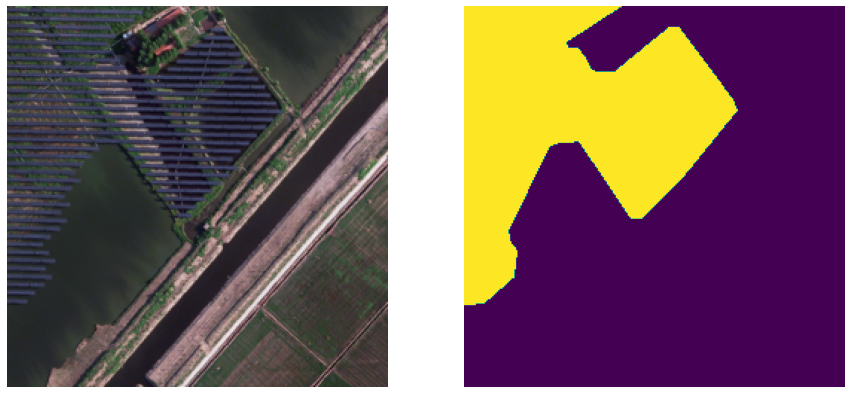

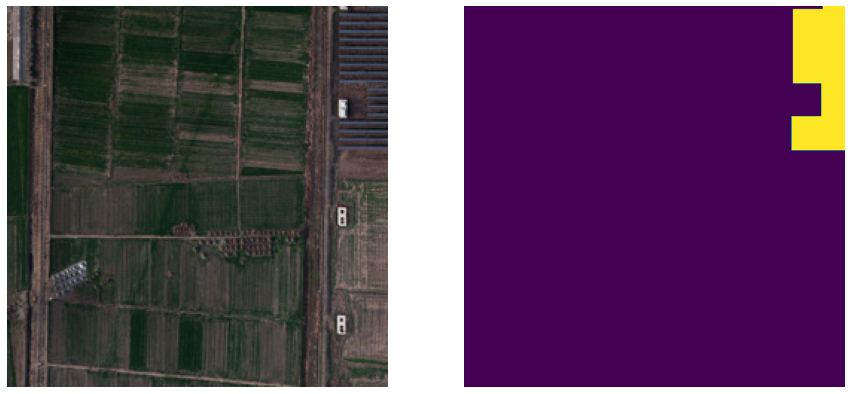

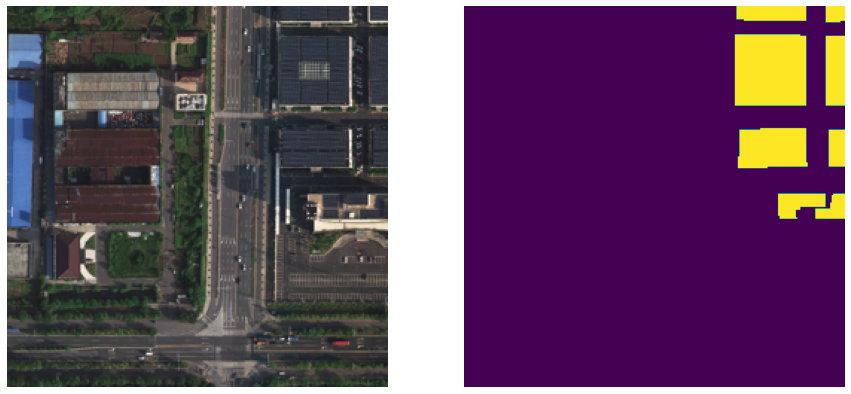

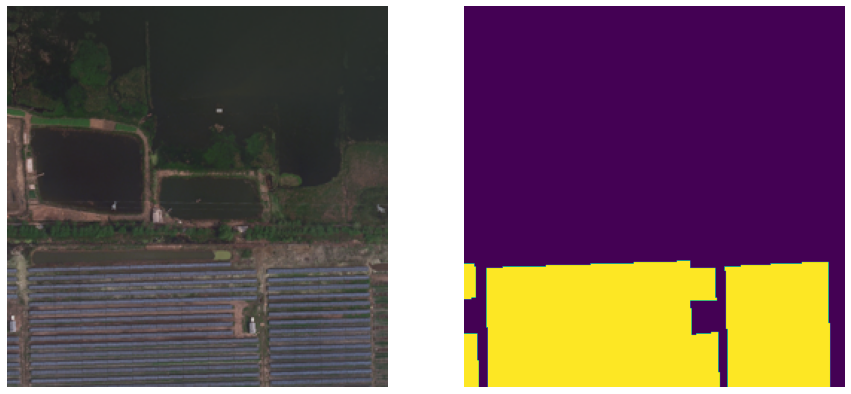

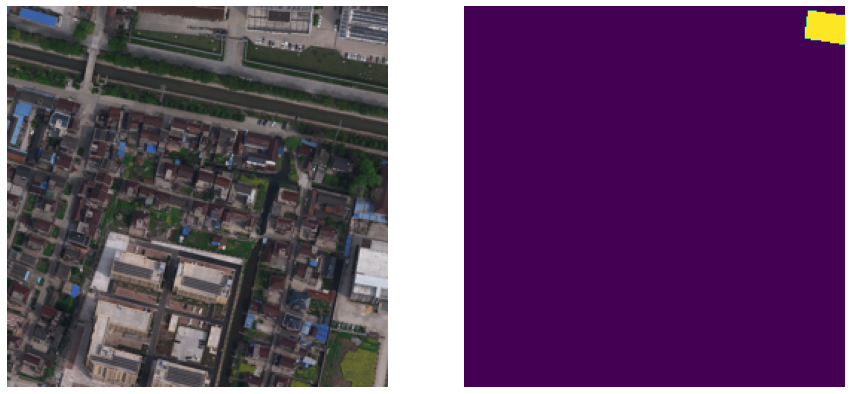

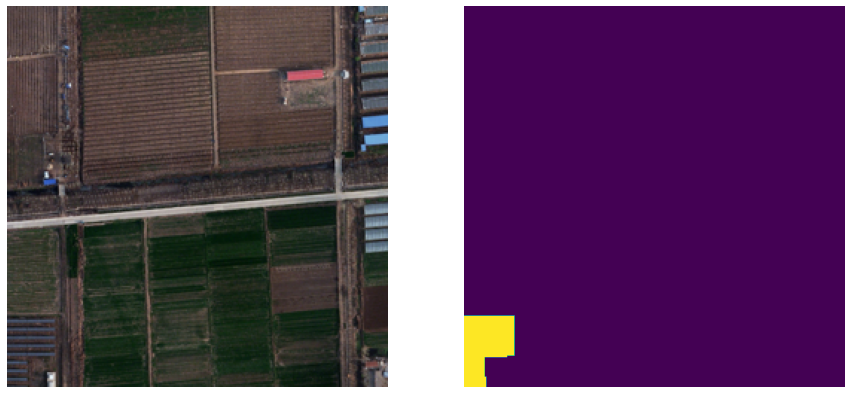

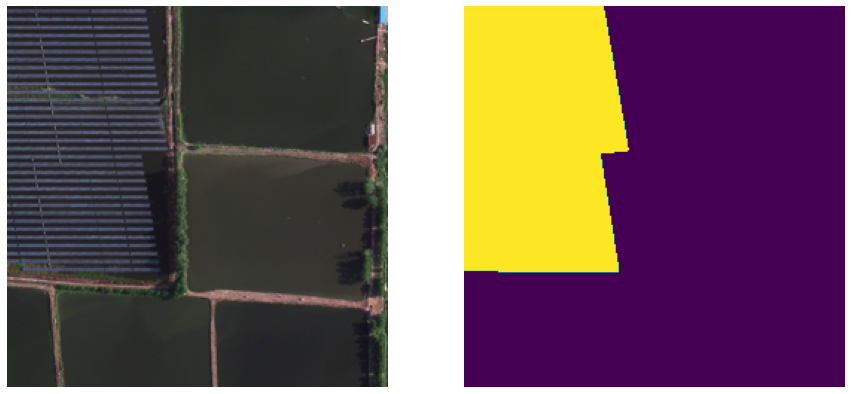

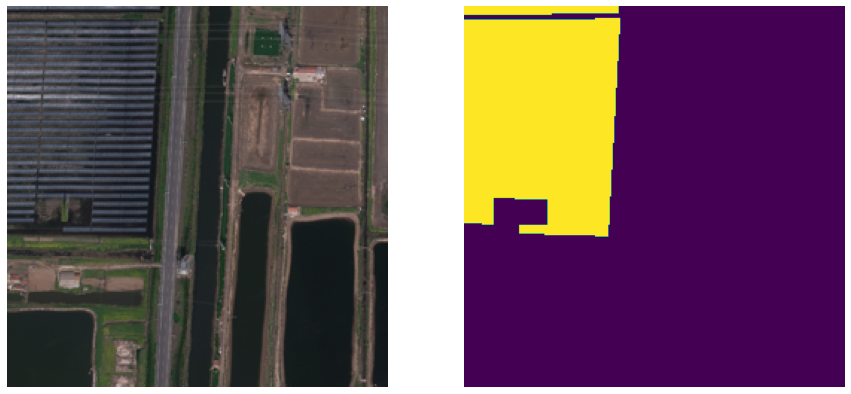

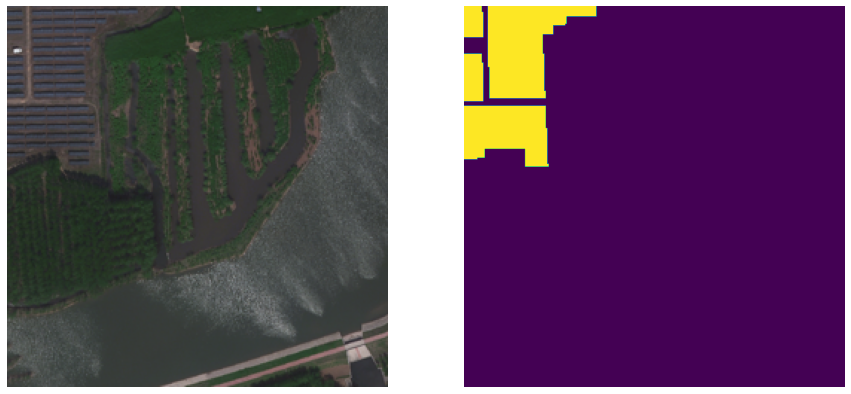

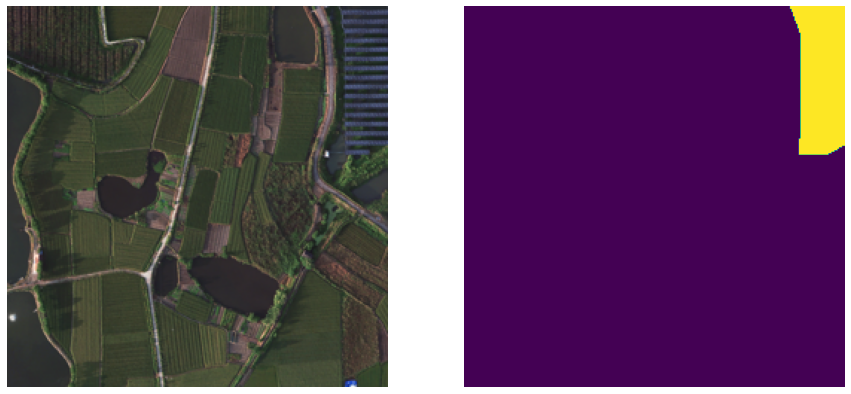

In [86]:
import matplotlib.pyplot as plt

def display(display_list):
    plt.figure(figsize=(15, 15))

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.imshow(display_list[i])
        plt.axis('off')

    plt.show()

# Now, you can use this modified display function to show your images
for i in range(5):
    for images, masks in train_dataset.take(i):
        sample_images, sample_masks = images, masks
        display([sample_images[0], sample_masks[0]])


# V. Model
---

We are going to use U-Net model. A U-Net consists of an encoder (downsampler) and decoder (upsampler). In-order to learn robust features, and reduce the number of trainable parameters, a pretrained model can be used as the encoder.The encoder will be a pretrained MobileNetV2 model which is prepared and ready to use in tf.keras.applications. 

In [87]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[256, 256, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [88]:
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    if norm_type.lower() == 'batchnorm':
        result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
        result.add(InstanceNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

        result.add(tf.keras.layers.ReLU())

    return result

up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]

In [89]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

  # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2, activation='sigmoid',
      padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

# VI. Training the Model
___

Now let's compile the model and see the model architecture

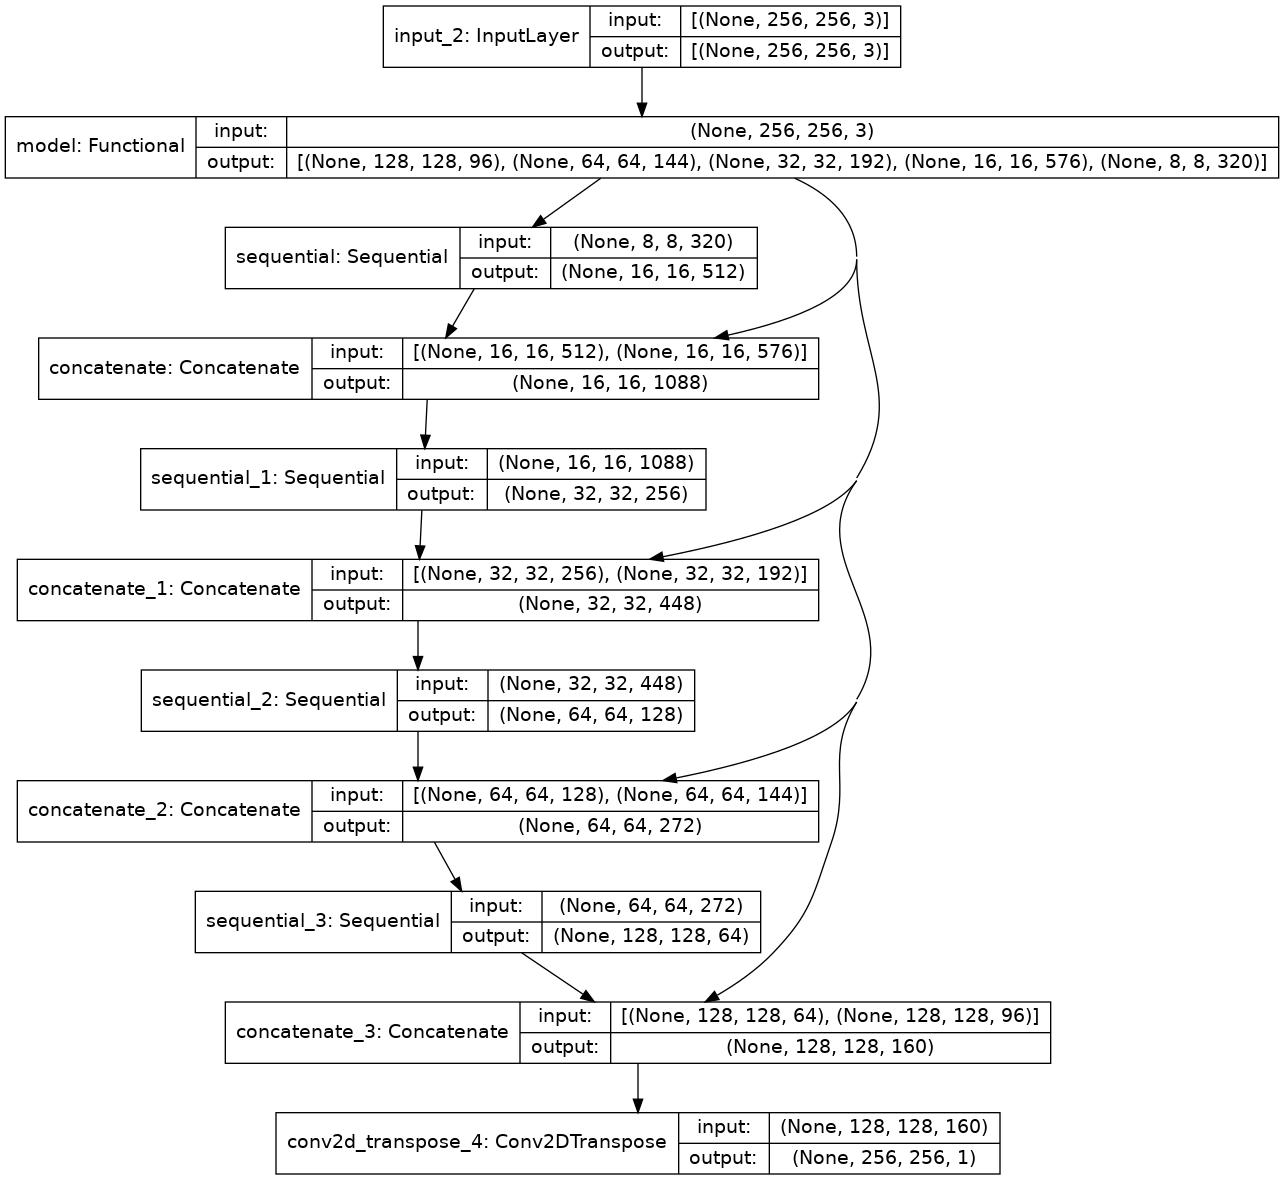

In [90]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_loss(in_gt, in_pred):
    return 1-dice_coef(in_gt, in_pred)

model = unet_model(1)

model.compile(optimizer='adam',
              loss = dice_loss,
              metrics=[dice_coef,'binary_accuracy'])

tf.keras.utils.plot_model(model, show_shapes=True)

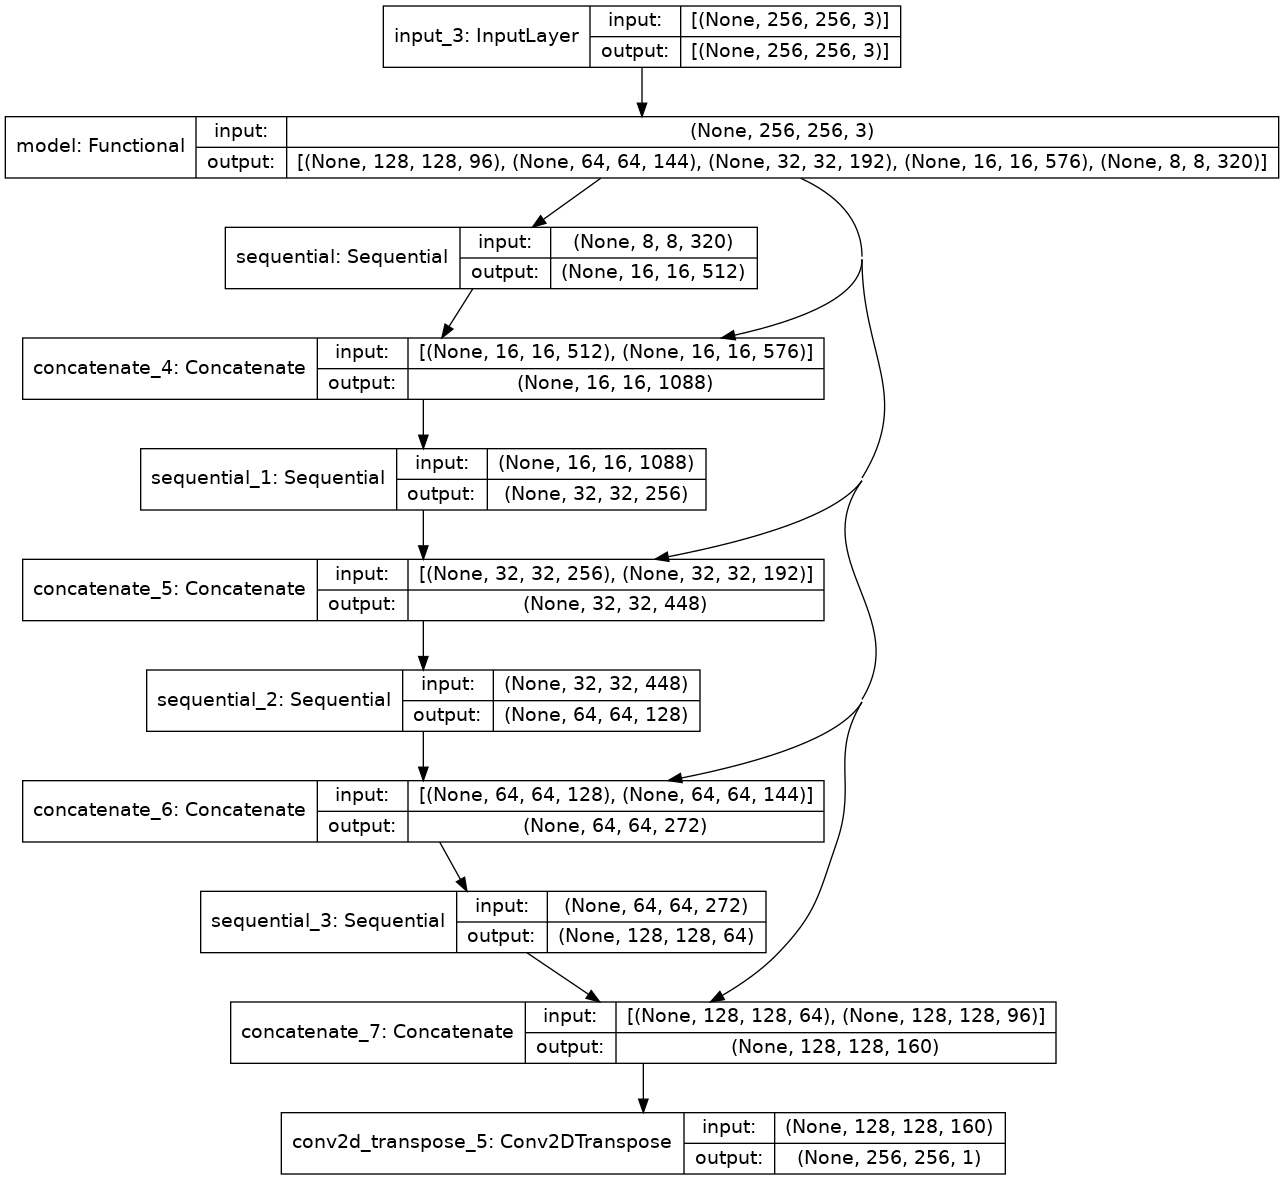

In [91]:
import tensorflow as tf
from tensorflow.keras import backend as K

# Assuming you have the unet_model function defined

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean((2. * intersection + smooth) / (union + smooth), axis=0)

def dice_loss(in_gt, in_pred):
    return 1 - dice_coef(in_gt, in_pred)

def iou_score(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3]) - intersection
    return K.mean((intersection + smooth) / (union + smooth), axis=0)

model = unet_model(1)

model.compile(optimizer='adam',
              loss=dice_loss,
              metrics=[dice_coef, 'binary_accuracy', iou_score])

tf.keras.utils.plot_model(model, show_shapes=True)


Let's try out the model to see what it predicts before training.

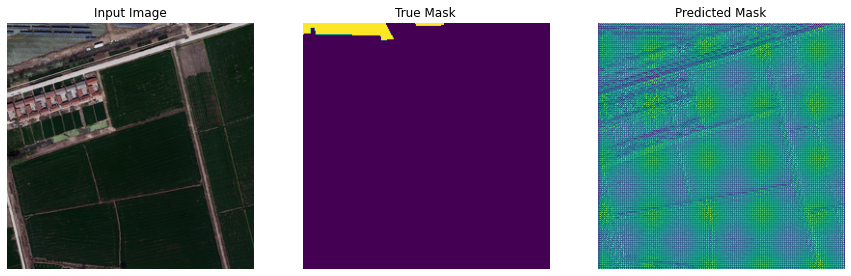

In [92]:
for images, masks in train_dataset.take(1):
    for img, mask in zip(images, masks):
        sample_image = img
        sample_mask = mask
        break
def visualize(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def show_predictions(sample_image, sample_mask):
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    pred_mask = pred_mask.reshape(img_size[0],img_size[1],1)
    visualize([sample_image, sample_mask, pred_mask])
    
show_predictions(sample_image, sample_mask)

In [93]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, 128, 128, 96 1841984     input_3[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 16, 16, 512)  1476608     model[1][4]                      
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 16, 16, 1088) 0           sequential[1][0]                 
                                                                 model[1][3]                

Epoch 1/30
67/67 [==============================] - 16s 137ms/step - loss: 0.4520 - dice_coef: 0.5480 - binary_accuracy: 0.7885 - iou_score: 0.4423 - val_loss: 0.1878 - val_dice_coef: 0.8108 - val_binary_accuracy: 0.9437 - val_iou_score: 0.7266
Epoch 2/30
67/67 [==============================] - 8s 110ms/step - loss: 0.1951 - dice_coef: 0.8097 - binary_accuracy: 0.9540 - iou_score: 0.7323 - val_loss: 0.1738 - val_dice_coef: 0.8259 - val_binary_accuracy: 0.9541 - val_iou_score: 0.7517
Epoch 3/30
67/67 [==============================] - 7s 109ms/step - loss: 0.1752 - dice_coef: 0.8236 - binary_accuracy: 0.9531 - iou_score: 0.7479 - val_loss: 0.1668 - val_dice_coef: 0.8324 - val_binary_accuracy: 0.9546 - val_iou_score: 0.7562
Epoch 4/30
67/67 [==============================] - 7s 109ms/step - loss: 0.1656 - dice_coef: 0.8368 - binary_accuracy: 0.9568 - iou_score: 0.7641 - val_loss: 0.1610 - val_dice_coef: 0.8389 - val_binary_accuracy: 0.9559 - val_iou_score: 0.7668
Epoch 5/30


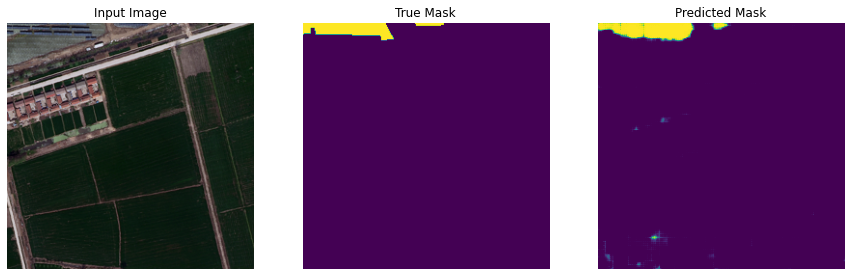

67/67 [==============================] - 8s 109ms/step - loss: 0.1553 - dice_coef: 0.8433 - binary_accuracy: 0.9601 - iou_score: 0.7690 - val_loss: 0.1653 - val_dice_coef: 0.8345 - val_binary_accuracy: 0.9556 - val_iou_score: 0.7606
Epoch 6/30
67/67 [==============================] - 7s 112ms/step - loss: 0.1632 - dice_coef: 0.8369 - binary_accuracy: 0.9570 - iou_score: 0.7657 - val_loss: 0.1701 - val_dice_coef: 0.8296 - val_binary_accuracy: 0.9539 - val_iou_score: 0.7537
Epoch 7/30
67/67 [==============================] - 7s 108ms/step - loss: 0.1625 - dice_coef: 0.8391 - binary_accuracy: 0.9583 - iou_score: 0.7688 - val_loss: 0.1687 - val_dice_coef: 0.8317 - val_binary_accuracy: 0.9569 - val_iou_score: 0.7621
Epoch 8/30
67/67 [==============================] - 7s 108ms/step - loss: 0.1616 - dice_coef: 0.8387 - binary_accuracy: 0.9567 - iou_score: 0.7685 - val_loss: 0.1659 - val_dice_coef: 0.8341 - val_binary_accuracy: 0.9563 - val_iou_score: 0.7631


In [94]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=4,restore_best_weights=True)

# Let's observe how the model improves while it is training. 
# To accomplish this task, a callback function is defined below.
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if (epoch + 1) % 5 == 0:
            show_predictions(sample_image, sample_mask)
EPOCHS = 30
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=valid_dataset,
                          callbacks=[DisplayCallback(), early_stop])

# VI. Inferance
---

In [109]:
model.compile(optimizer='adam',
              loss=dice_loss,
              metrics=[dice_coef, 'binary_accuracy', 'iou_score'])  # Change 'iou_score' to match the name used in metrics


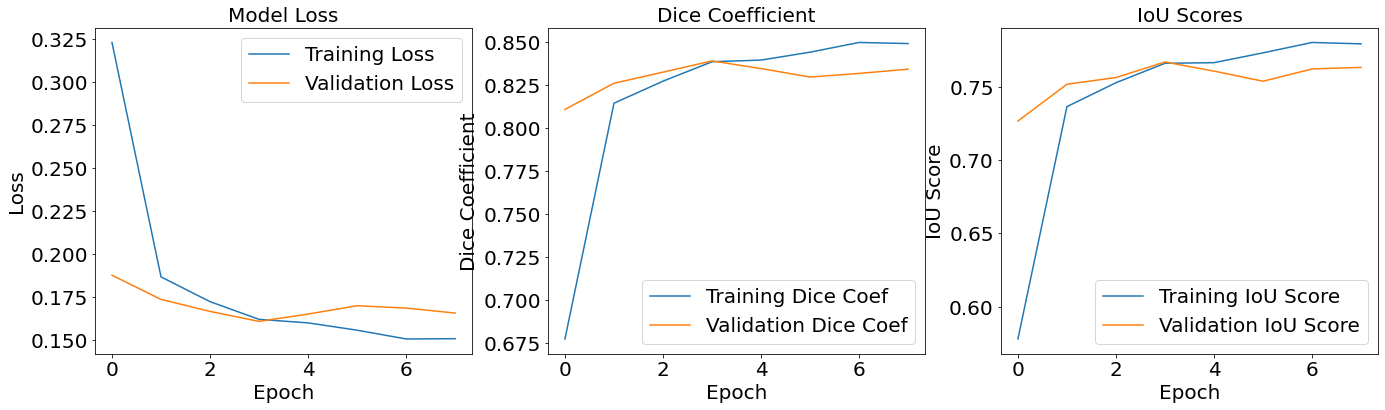

In [153]:
# Assuming you have already trained your model and have the history
# Make sure to include validation data during model training

import matplotlib.pyplot as plt

# Set a larger font size
font_size = 20
plt.rcParams.update({'font.size': font_size})

# Plot loss
plt.figure(figsize=(23, 6))
plt.subplot(1, 3, 1)
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss', fontsize=font_size)
plt.xlabel('Epoch', fontsize=font_size)
plt.ylabel('Loss', fontsize=font_size)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=font_size)

# Plot dice coefficient
plt.subplot(1, 3, 2)
plt.plot(model_history.history['dice_coef'])
plt.plot(model_history.history['val_dice_coef'])
plt.title('Dice Coefficient', fontsize=font_size)
plt.xlabel('Epoch', fontsize=font_size)
plt.ylabel('Dice Coefficient', fontsize=font_size)
plt.legend(['Training Dice Coef', 'Validation Dice Coef'], fontsize=font_size)

# Plot IoU score
plt.subplot(1, 3, 3)
plt.plot(model_history.history['iou_score'])
plt.plot(model_history.history['val_iou_score'])
plt.title('IoU Scores', fontsize=font_size)
plt.xlabel('Epoch', fontsize=font_size)
plt.ylabel('IoU Score', fontsize=font_size)
plt.legend(['Training IoU Score', 'Validation IoU Score'], fontsize=font_size)

plt.show()


# VI. Save and Load the Model 
---

In [100]:
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [115]:
# Check the shape of elements in the preprocessed test dataset
for test_image, test_mask in preprocessed_test_dataset.take(1):
    print("Test Image Shape:", test_image.shape)
    print("Test Mask Shape:", test_mask.shape)


Test Image Shape: (256, 256, 3)
Test Mask Shape: (256, 256, 1)


In [135]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if (epoch + 1) % 5 == 0:
            show_predictions(sample_image, sample_mask)

# Define a callback function to display test predictions during training
class DisplayTestCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 5 == 0:
            show_test_predictions(self.model, test_dataset, preprocess_fn)


In [133]:
EPOCHS = 30
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
threshold = 0.5

for item in test_dataset.shuffle(10).take(10):
        image = item[0]
        true_mask = item[1]
        mask_4d = model.predict(np.expand_dims(image, axis=(0)))
        pred_mask_proba = np.squeeze(mask_4d, axis=0)
        pred_mask = np.where(pred_mask_proba > threshold, 1, 0)
        
        show_images((image, true_mask, pred_mask_proba, pred_mask), ["Image", "True Mask", "Model Probability", "Model Prediciton @0.5"])

In [ ]:
model.evaluate(test_dataset.batch(batch_size))